In [1]:
import pandas as pd
import seaborn as sns
from sktime.forecasting.ets import AutoETS
import matplotlib.pyplot as plt
from pylab import rcParams

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from src.data.loaders import CommodityLoader
from src.utils.split_series import split_series
from src.evaluation.evaluation import MetricEvaluator

from pylab import rcParams
import warnings

In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 
}
plt.rcParams.update(dark_style)
rcParams['figure.figsize'] = (18,7)

In [3]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

warnings.filterwarnings("ignore")

In [4]:
df_brl = CommodityLoader.load_all_commodities(
    currency='BRL',
    preprocessing=True,
    monthly_aggregation='mean',
    limit_date=None
)

df_test = df_brl[df_brl['unique_id'] == 'ALGODAO']

ദ്ദി・ᴗ・)✧ acucar_santos carregado com sucesso
ദ്ദി・ᴗ・)✧ acucar_sp carregado com sucesso
ദ്ദി・ᴗ・)✧ algodao carregado com sucesso
ദ്ദി・ᴗ・)✧ arroz carregado com sucesso


ദ്ദി・ᴗ・)✧ cafe_arabica carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_robusta carregado com sucesso
ദ്ദി・ᴗ・)✧ milho carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_paranagua carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_rs carregado com sucesso


In [5]:
def rolling_forecast_autoets(df, ratio=0.3):
    df = df.sort_values('ds')
    df['ds'] = pd.to_datetime(df['ds']).dt.to_period("M")
    y = pd.Series(df['y'].values, index=df['ds'])
    horizon = max(1, int(len(y) * ratio))
    train, test = y.iloc[:-horizon], y.iloc[-horizon:]


    forecaster = AutoETS()
    forecaster.fit(train)

    y_preds = []
    for t in test:
        y_pred = forecaster.predict(fh=[1]).iloc[0]
        y_preds.append(y_pred)
        forecaster.update(
            y=pd.Series([t], index=[test.index[0]]),
            update_params=False
        )
        # y_pred = forecaster.update_predict_single(
        #     y=pd.Series([t], index=[test.index[0]]),
        #     fh=[1],
        #     update_params=False
        # )
        # y_preds.append(y_pred.iloc[0])

    return pd.DataFrame({
        'ds': test.index,
        'y_true': test.values,
        'y_pred': y_preds
    })

In [6]:
results = (df_brl
           .groupby('unique_id')
           .apply(rolling_forecast_autoets, ratio=0.3)
           .reset_index())

/tmp/ipykernel_4196/1150358243.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = (df_brl


In [7]:
results.head()

,unique_id,level_1,ds,y_true,y_pred
0,ACUCAR_SANTOS,0,2023-11,172.731500,176.677368
1,ACUCAR_SANTOS,1,2023-12,149.326842,176.677368
2,ACUCAR_SANTOS,2,2024-01,154.029545,176.677368
3,ACUCAR_SANTOS,3,2024-02,157.357368,176.677368
4,ACUCAR_SANTOS,4,2024-03,152.284500,176.677368


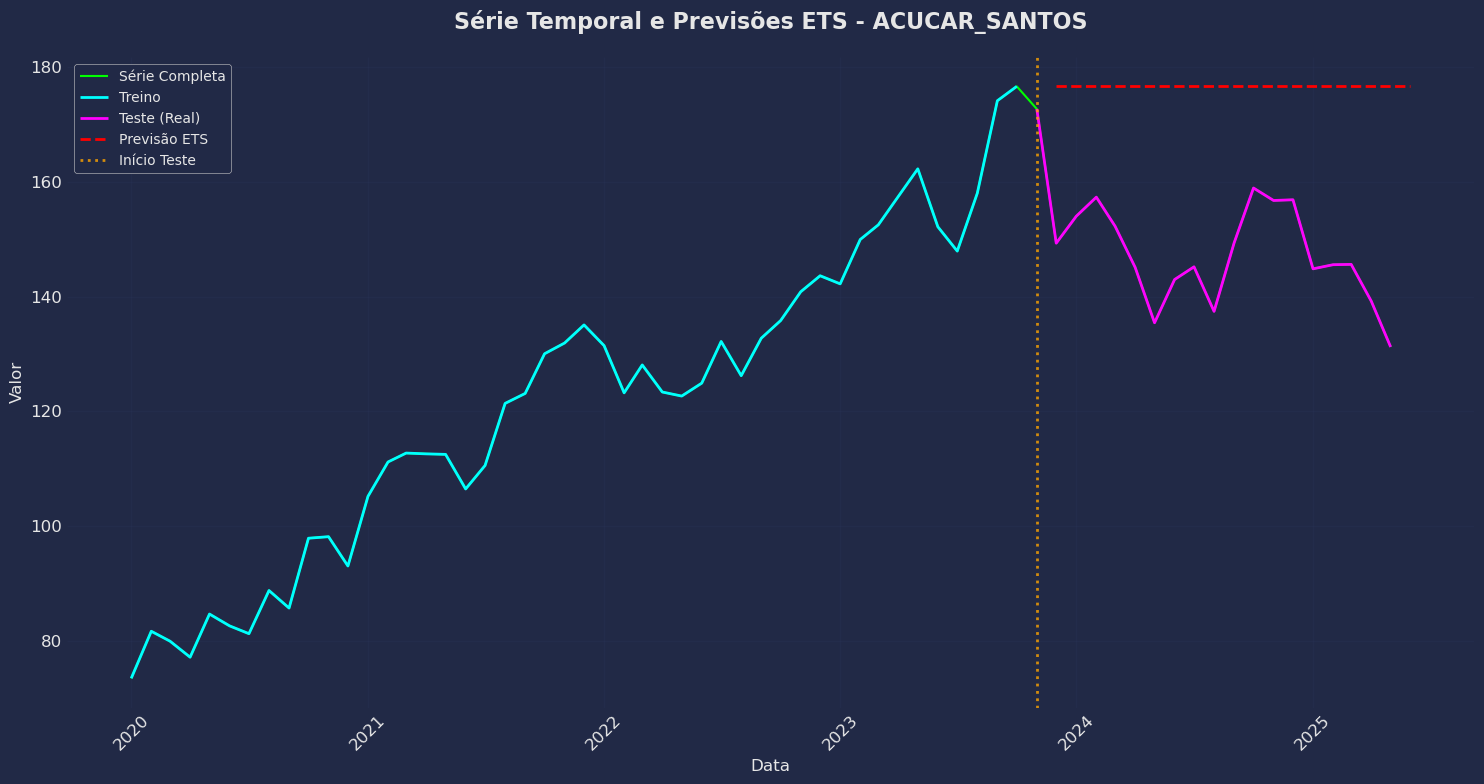

Gráfico exibido para: ACUCAR_SANTOS
--------------------------------------------------


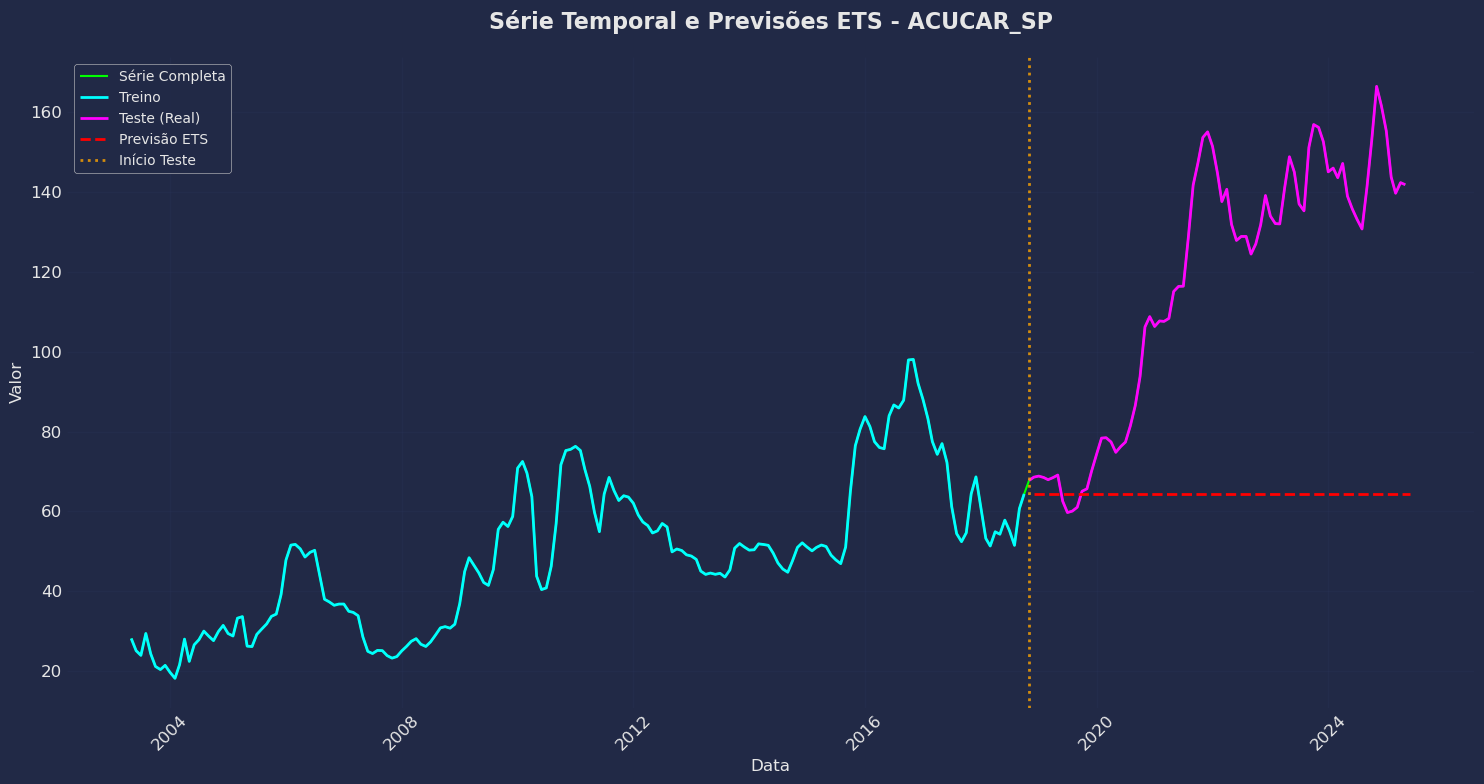

Gráfico exibido para: ACUCAR_SP
--------------------------------------------------


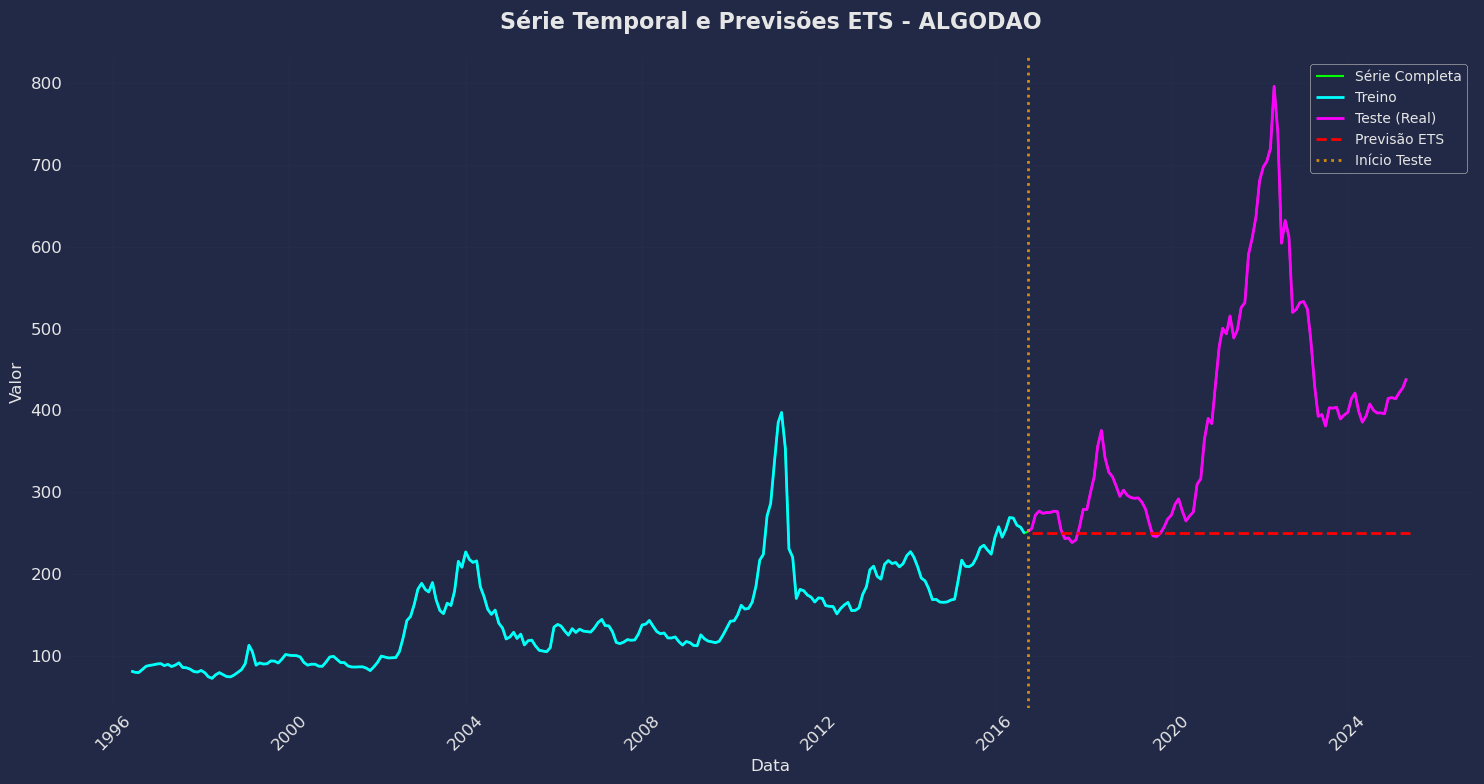

Gráfico exibido para: ALGODAO
--------------------------------------------------


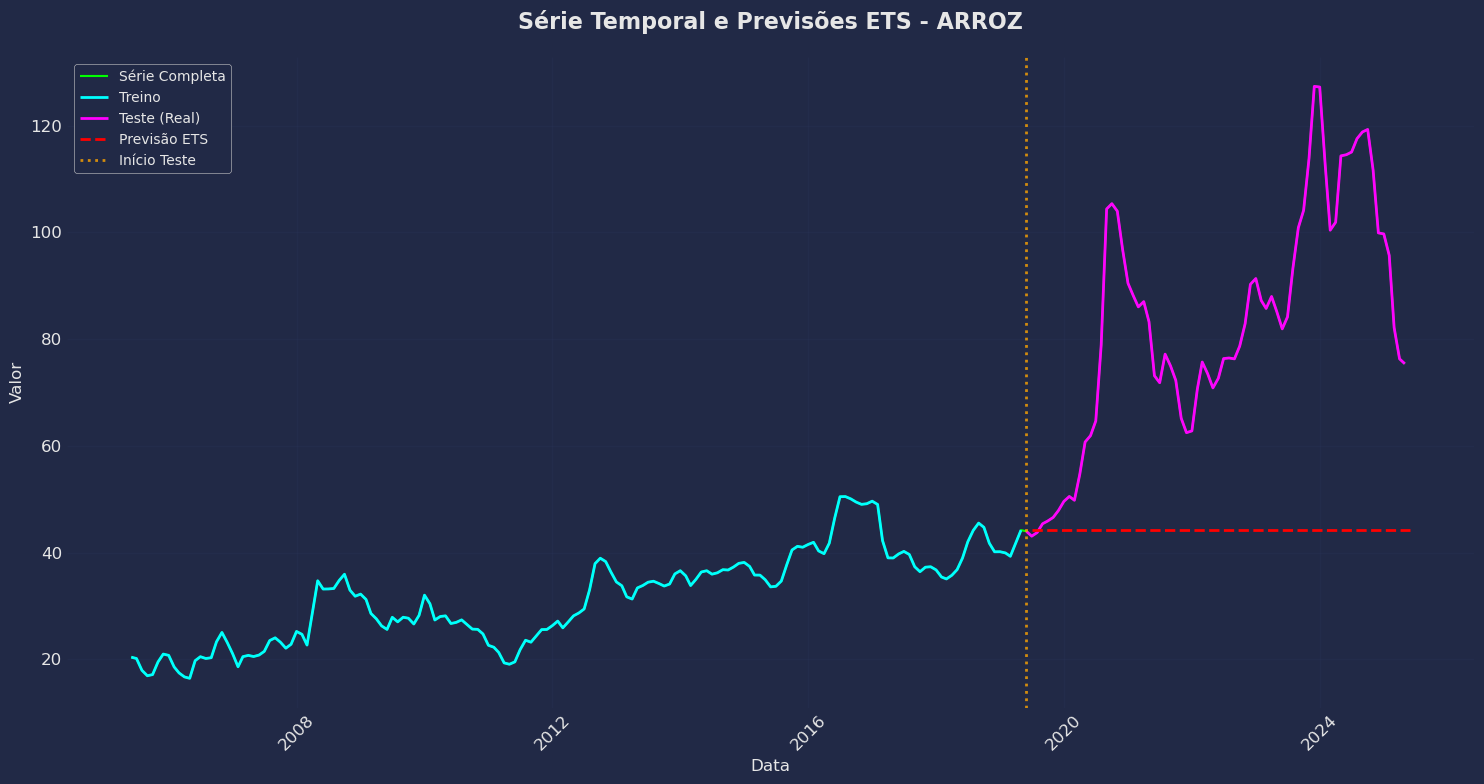

Gráfico exibido para: ARROZ
--------------------------------------------------


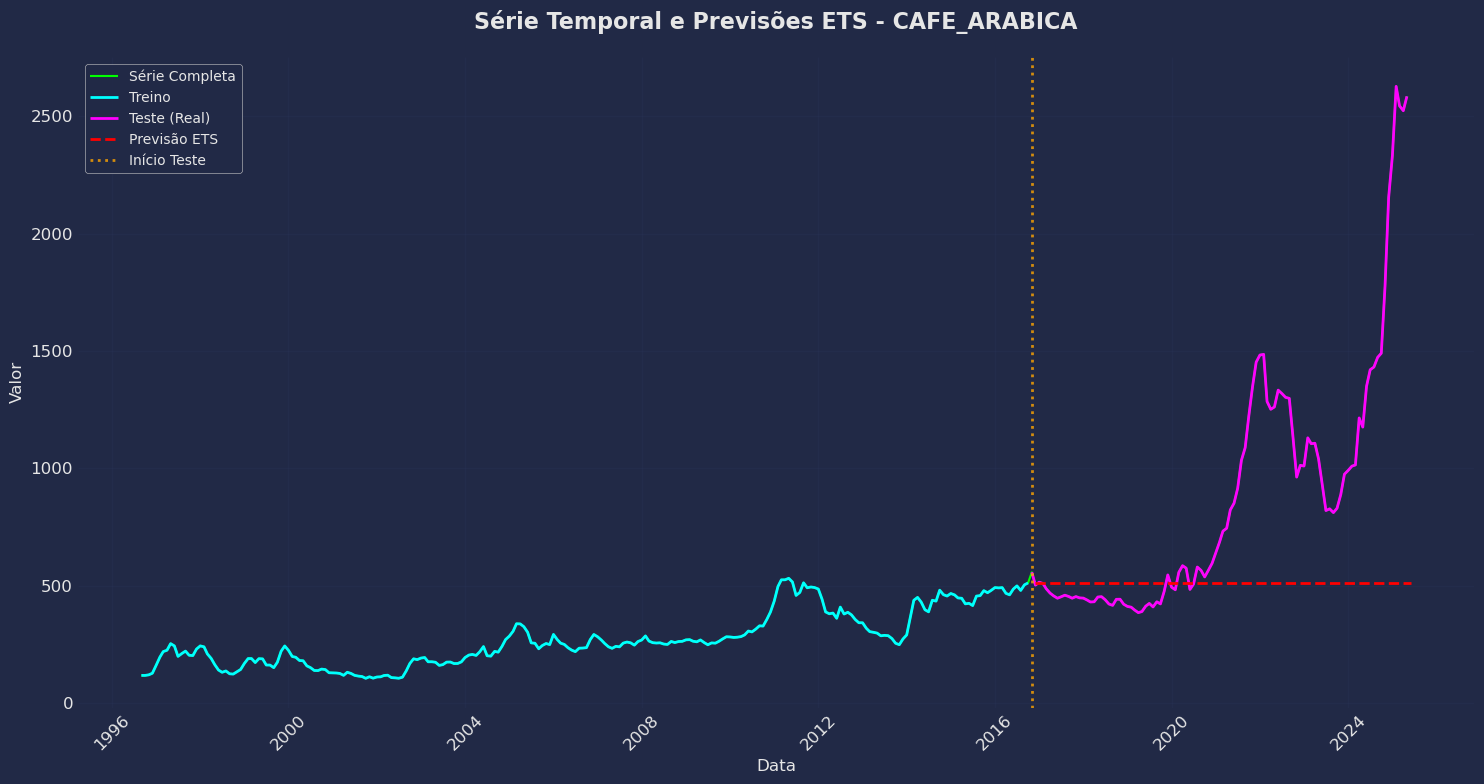

Gráfico exibido para: CAFE_ARABICA
--------------------------------------------------


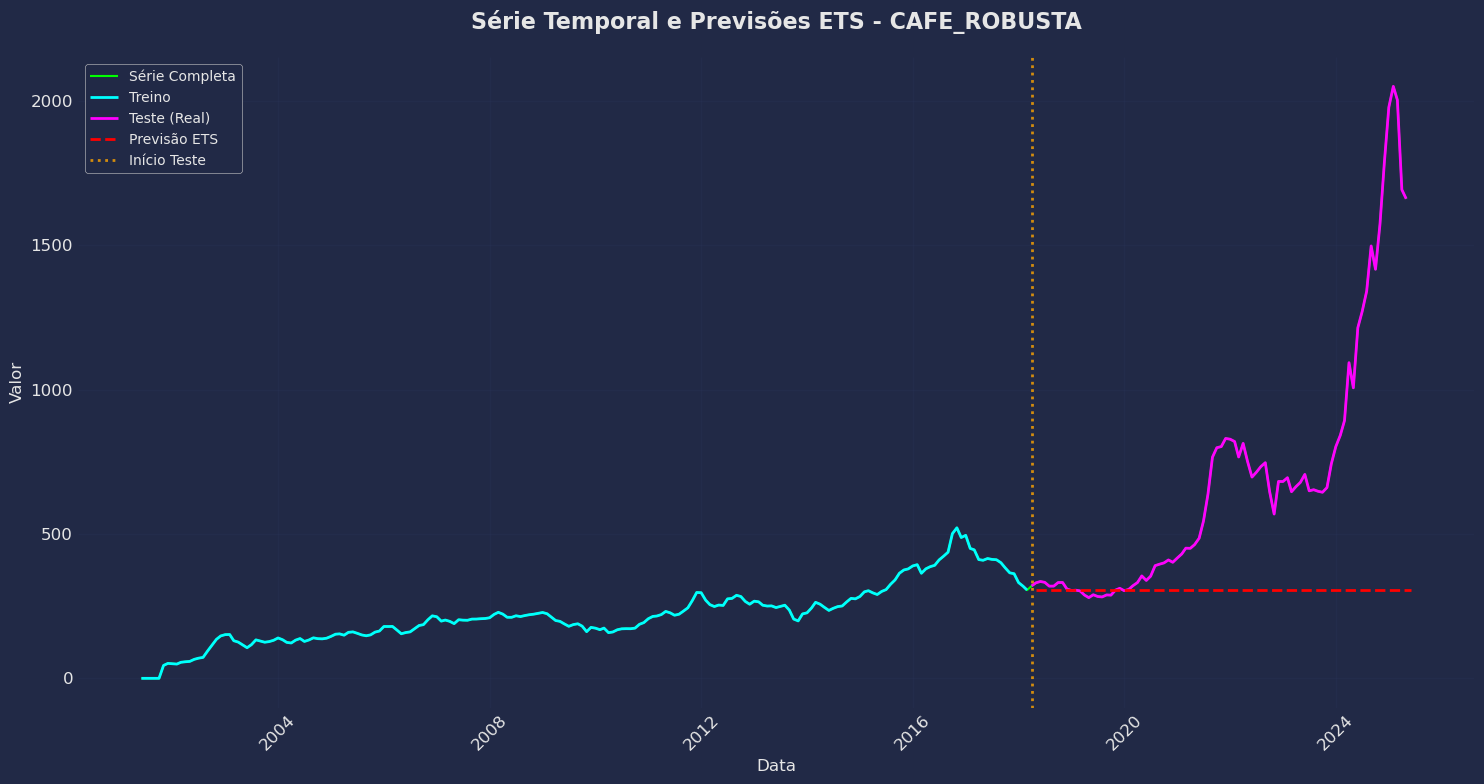

Gráfico exibido para: CAFE_ROBUSTA
--------------------------------------------------


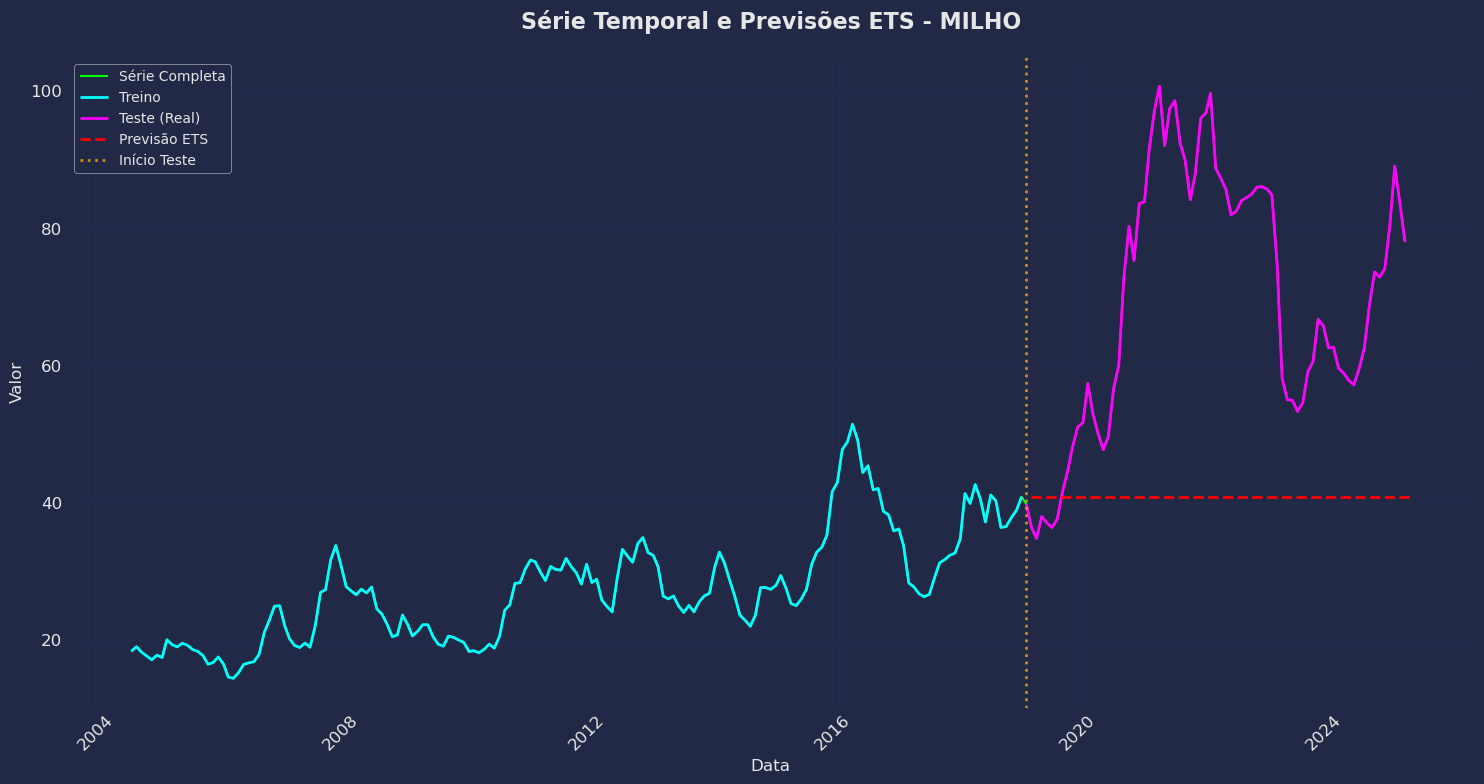

Gráfico exibido para: MILHO
--------------------------------------------------


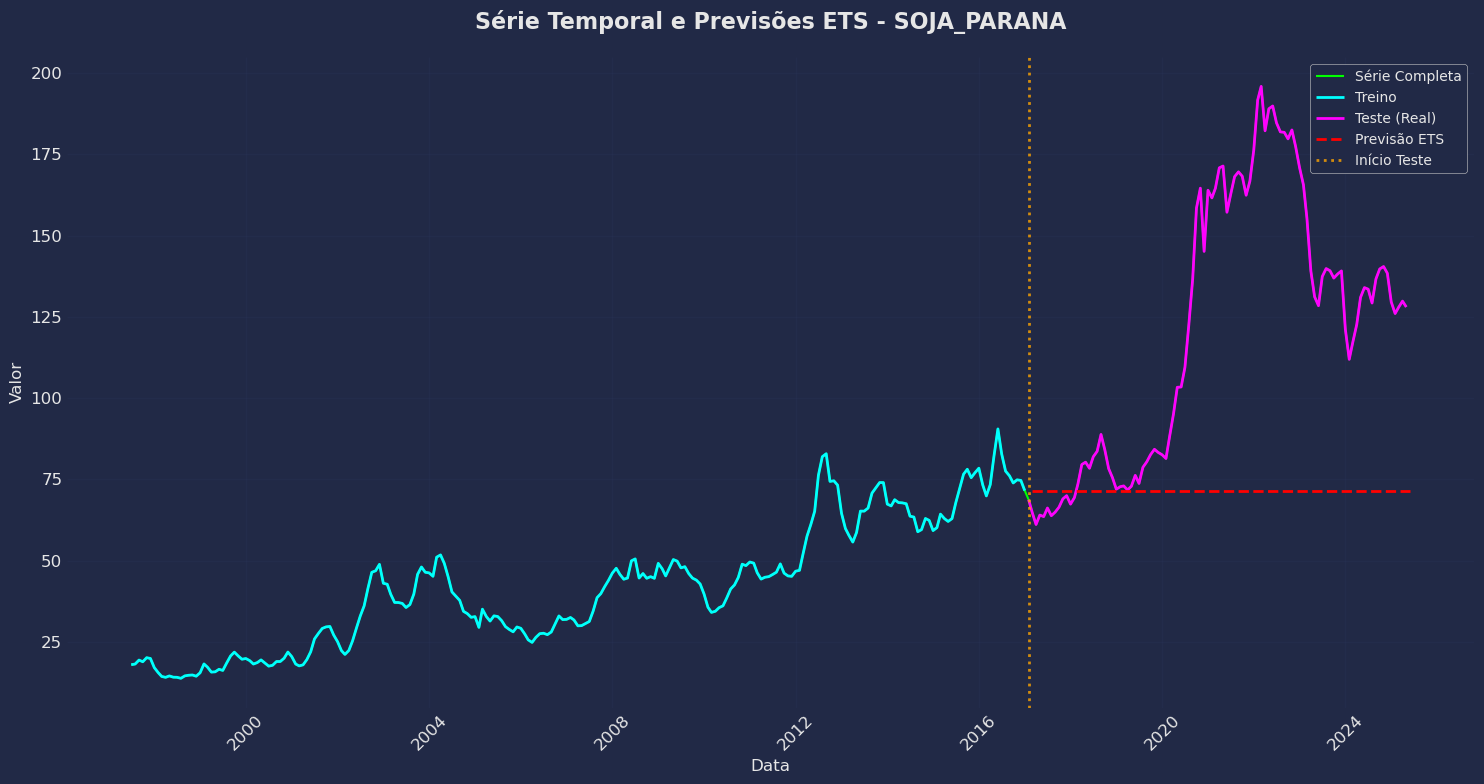

Gráfico exibido para: SOJA_PARANA
--------------------------------------------------


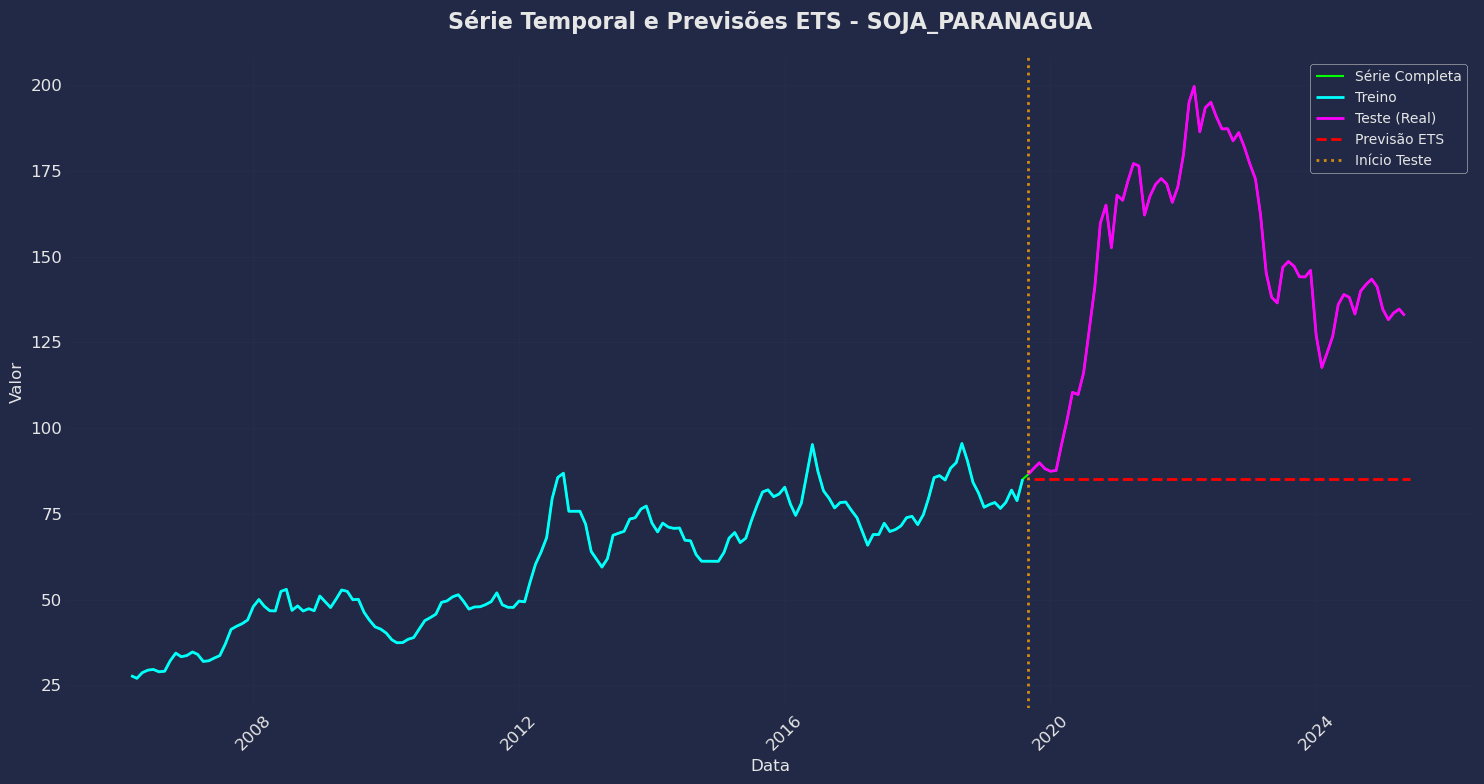

Gráfico exibido para: SOJA_PARANAGUA
--------------------------------------------------


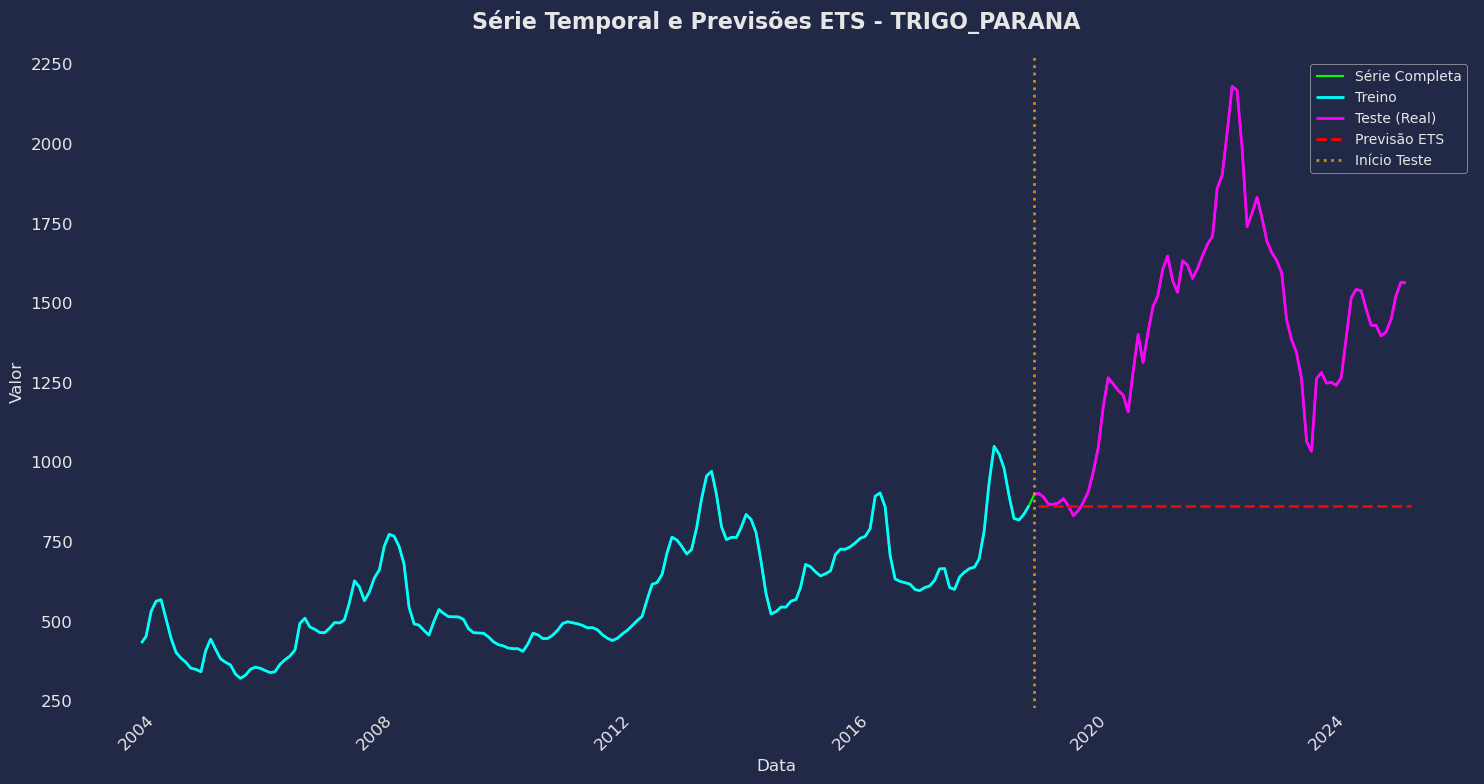

Gráfico exibido para: TRIGO_PARANA
--------------------------------------------------


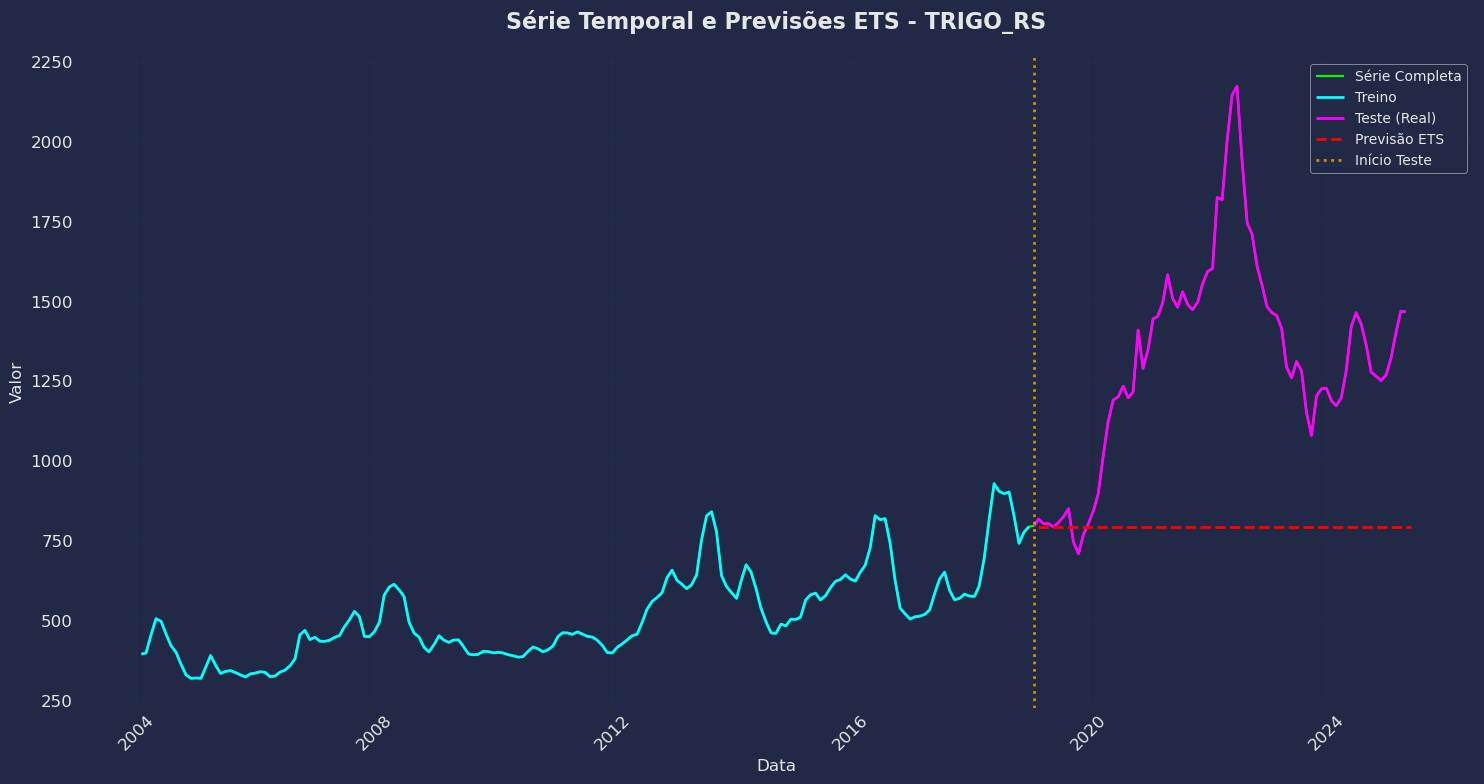

Gráfico exibido para: TRIGO_RS
--------------------------------------------------


In [8]:
def plot_series_and_forecasts_arima(df_brl, results, ratio=0.3):
    """
    Plota a série completa, treino, teste e previsões one-step do ETS
    """
    unique_ids = df_brl['unique_id'].unique()
    
    for uid in unique_ids:
        fig, ax = plt.subplots(1, 1, figsize=(15, 8))
        
        # Série completa
        series_data = df_brl[df_brl['unique_id'] == uid].copy().sort_values("ds")
        N = len(series_data)
        H = max(1, int(N * ratio))
        train_data = series_data.iloc[:-H]
        test_data = series_data.iloc[-H:]
        
        # Previsões geradas no rollout
        forecast_data = results[results['unique_id'] == uid].copy().sort_values("ds")
        
        # === Plots ===
        ax.plot(series_data['ds'], series_data['y'], 
                color='lime', linewidth=1.5, label='Série Completa')
        
        ax.plot(train_data['ds'], train_data['y'], 
                color='cyan', linewidth=2, label='Treino')
        
        ax.plot(test_data['ds'], test_data['y'], 
                color='fuchsia', linewidth=2, label='Teste (Real)')
        
        ax.plot(forecast_data['ds'], forecast_data['y_pred'], 
                color='red', linewidth=2, linestyle='--', label='Previsão ETS')
        
        if len(test_data) > 0:
            ax.axvline(x=test_data['ds'].iloc[0], color='orange', 
                      linestyle=':', alpha=0.8, linewidth=2, label='Início Teste')
        
        # Configurações visuais
        ax.set_title(f'Série Temporal e Previsões ETS - {uid}', 
                    fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('Data', fontsize=12)
        ax.set_ylabel('Valor', fontsize=12)
        ax.legend(fontsize=10, loc='best')
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        print(f"Gráfico exibido para: {uid}")
        print("-" * 50)


plot_series_and_forecasts_arima(df_brl, results, ratio=0.3)